## Importing Libraries

In [1]:
import mne
print('MNE-Python version: ', mne.__version__)

import numpy as np
print('Numpy version: ', np.__version__)

import matplotlib.pyplot as plt

import pycrostates
print('Pycrostates version: ', pycrostates.__version__)

import sklearn
print('SKLearn version: ', sklearn.__version__)

mne.set_log_level('error')  # reduce extraneous MNE output

MNE-Python version:  1.4.2
Numpy version:  1.24.3
Pycrostates version:  0.3.0
SKLearn version:  1.2.2


## Importing the preprocessed data

C:\Users\Divya Tiwari\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


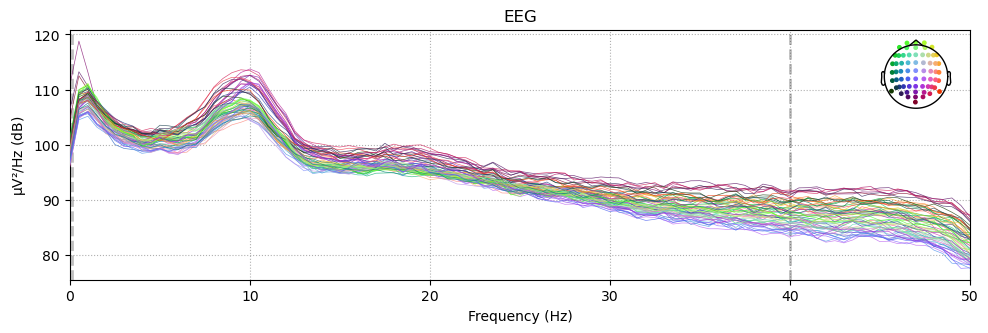

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2021-08-24 11:04:08 UTC
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 1024.0 Hz
>

In [2]:
data = mne.io.read_raw_fif("D:\IIIT_Hyderabad\Code\last_files\data.fif", preload = True)
data.plot()
data.plot_psd(fmax = 50)
plt.show()
data.info

In [3]:
data.set_eeg_reference('average')

<Raw | data.fif, 64 x 217088 (212.0 s), ~106.1 MB, data loaded>

In [5]:
tstep = 2.0
events = mne.make_fixed_length_events(data, duration=tstep)
epochs = mne.Epochs(data, events,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

### Global Field Power

In [6]:
from pycrostates.preprocessing import extract_gfp_peaks
gfp_data = extract_gfp_peaks(epochs)
gfp_data

< ChData | 6628 samples >

## Modified KMeans cluster = 5

In [9]:
from pycrostates.cluster import ModKMeans

n_clusters = 5
ModK = ModKMeans(n_clusters=n_clusters,
                 n_init=100, max_iter=300,
                 tol=1e-10, random_state=42)

In [10]:
ModK.fit(gfp_data, n_jobs=5)

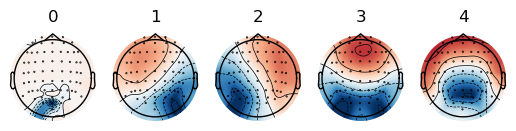

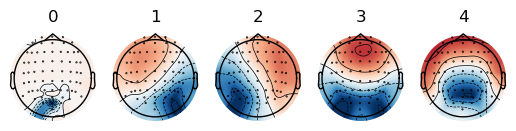

In [11]:
ModK.plot()

In [12]:
ModK.GEV_

0.6519410911412429

In [13]:
ModK.invert_polarity([True, True, True, True, False])

In [14]:
ModK.reorder_clusters(order=[1, 2, 4, 3, 0])
ModK.rename_clusters(new_names=["A", "B", "C", "D", "F"])

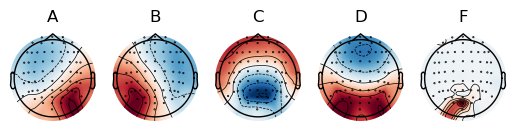

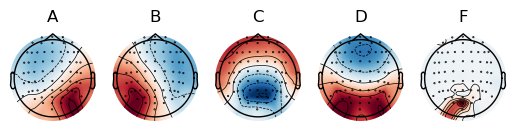

In [15]:
ModK.plot()

### Microstate Segmentation

In [17]:
segmentation = ModK.predict(
    data,
    reject_by_annotation=True,
    factor=5,
    half_window_size=5,
    min_segment_length=3,
    reject_edges=True,
)

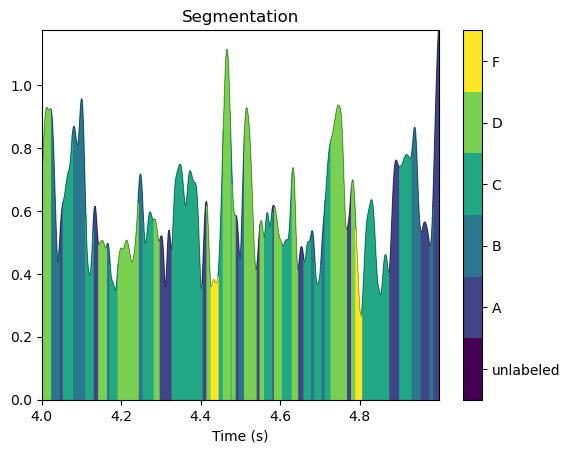

In [18]:
segmentation.plot(tmin = 4, tmax = 5)
plt.show()

In [19]:
parameters = segmentation.compute_parameters()
parameters

{'A_mean_corr': 0.662300288189893,
 'A_gev': 0.12083134507624615,
 'A_occurrences': 12.31364635309403,
 'A_timecov': 0.2379576773694177,
 'A_meandurs': 0.01932471264367816,
 'B_mean_corr': 0.6186846787055195,
 'B_gev': 0.0817166646144983,
 'B_occurrences': 12.054163383967527,
 'B_timecov': 0.2196943519145623,
 'B_meandurs': 0.018225599315068494,
 'C_mean_corr': 0.6491571297340436,
 'C_gev': 0.1369064638528638,
 'C_occurrences': 12.360825074753395,
 'C_timecov': 0.2597824434339106,
 'C_meandurs': 0.021016594107824426,
 'D_mean_corr': 0.7285890755235821,
 'D_gev': 0.1957949876836361,
 'D_occurrences': 12.558975705722723,
 'D_timecov': 0.25803167055983267,
 'D_meandurs': 0.020545598351803154,
 'F_mean_corr': 0.5184152839283764,
 'F_gev': 0.05988130742906727,
 'F_occurrences': 1.6748446189074255,
 'F_timecov': 0.02453385672227674,
 'F_meandurs': 0.0146484375,
 'unlabeled': 0.00018886350235849058}

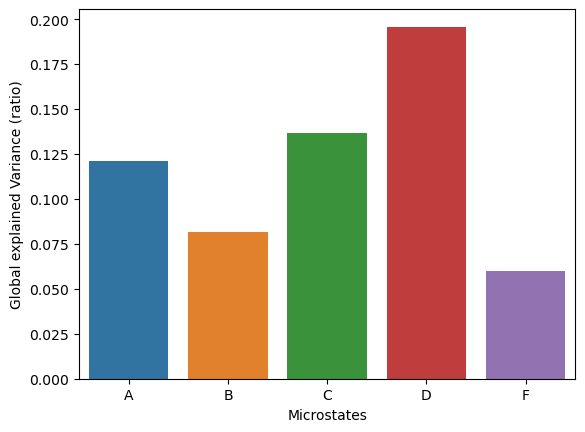

In [20]:
import seaborn as sns
x = ModK.cluster_names
y = [parameters[elt + "_gev"] for elt in x]

ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Global explained Variance (ratio)")
plt.show()

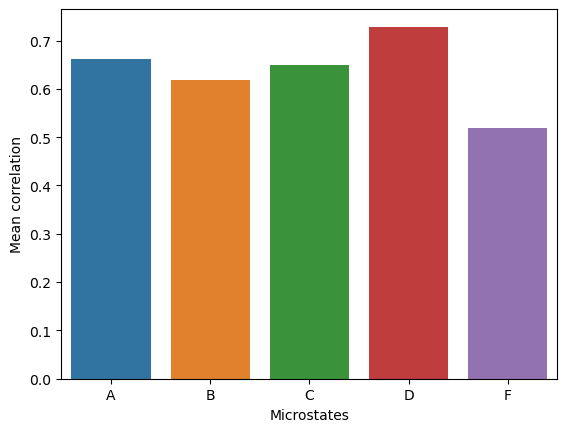

In [21]:
x = ModK.cluster_names
y = [parameters[elt + "_mean_corr"] for elt in x]

ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Mean correlation")
plt.show()

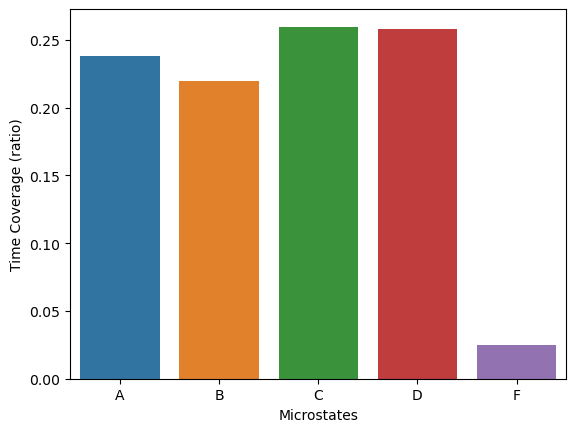

In [22]:
x = ModK.cluster_names
y = [parameters[elt + "_timecov"] for elt in x]

ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Time Coverage (ratio)")
plt.show()

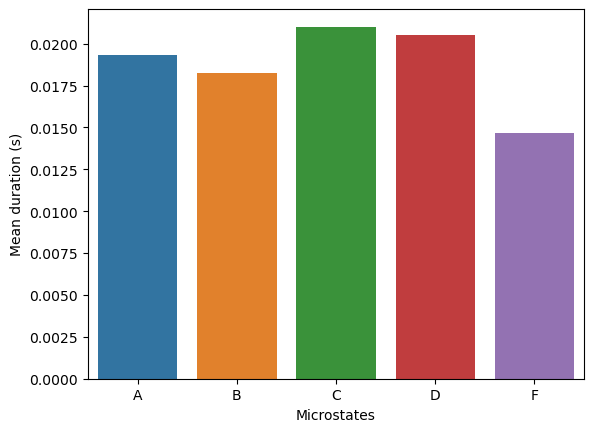

In [23]:
x = ModK.cluster_names
y = [parameters[elt + "_meandurs"] for elt in x]

ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Mean duration (s)")
plt.show()

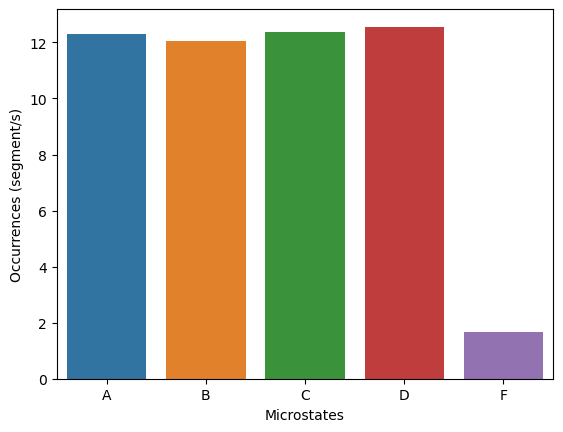

In [24]:
x = ModK.cluster_names
y = [parameters[elt + "_occurrences"] for elt in x]

ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel('Occurrences (segment/s)')
plt.show()

In [25]:
parameters = segmentation.compute_parameters(return_dist=True)

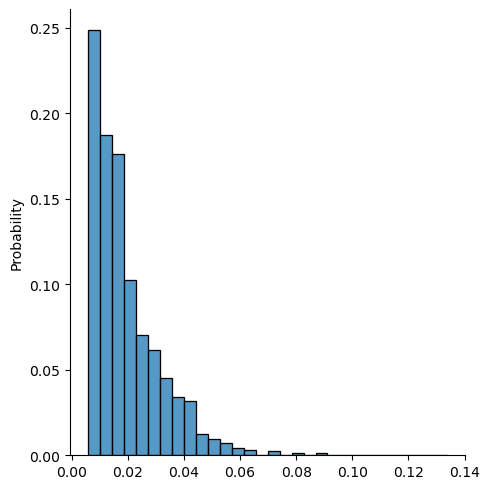

In [26]:
sns.displot(parameters['A_dist_durs'], stat='probability', bins=30)
plt.show()

In [27]:
median = np.median(parameters['C_dist_durs'])
print(f"Microstate C segments have a median duration of {median:.2f}s.")

Microstate C segments have a median duration of 0.02s.


In [28]:
T_observed = segmentation.compute_transition_matrix()

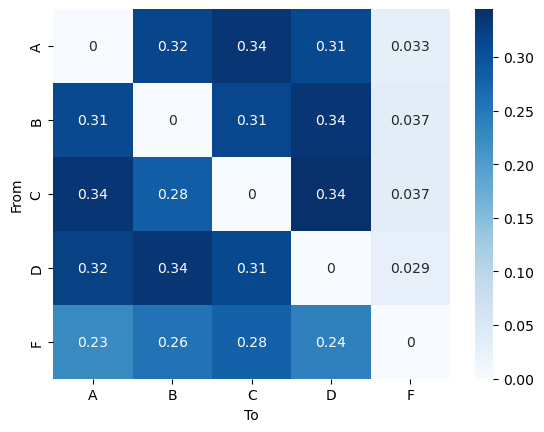

In [29]:
ax = sns.heatmap(
    T_observed,
    annot=True,
    cmap="Blues",
    xticklabels=segmentation.cluster_names,
    yticklabels=segmentation.cluster_names,
)
ax.set_ylabel("From")
ax.set_xlabel("To")
plt.show()

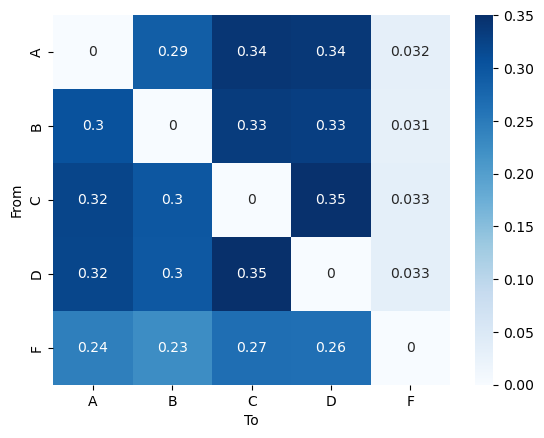

In [30]:
T_expected = segmentation.compute_expected_transition_matrix()
ax = sns.heatmap(
    T_expected,
    annot=True,
    cmap="Blues",
    xticklabels=segmentation.cluster_names,
    yticklabels=segmentation.cluster_names,
)
ax.set_ylabel("From")
ax.set_xlabel("To")
plt.show()

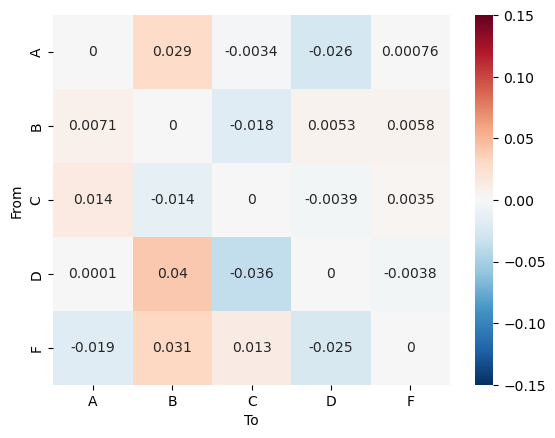

In [31]:
ax = sns.heatmap(
    T_observed - T_expected,
    annot=True,
    cmap="RdBu_r",
    vmin=-0.15,
    vmax=0.15,
    xticklabels=segmentation.cluster_names,
    yticklabels=segmentation.cluster_names,
)
ax.set_ylabel("From")
ax.set_xlabel("To")
plt.show()